# Cell 1: Install and Import

In [14]:
# Install required packages for Python 3.7
#import subprocess
#import sys

#packages = ['seaborn', 'plotly', 'kaleido']
#for package in packages:
#    try:
#        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
#    except:
#        print(f"Could not install {package}, continuing without it")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set_style("whitegrid")
except ImportError:
    print("Seaborn not available, using matplotlib only")
    sns = None

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Simple MongoDB-only Cell

In [15]:
def simple_mongodb_query():
    """
    Simple MongoDB query matching your PHP script exactly
    """
    import pymongo
    from datetime import datetime
    import pandas as pd
    
    # Connect (equivalent to new MongoDB\Driver\Manager)
    client = pymongo.MongoClient("mongodb://localhost:27017")
    
    # Query (equivalent to new MongoDB\Driver\Query with sort)
    collection = client.messages.ReceivedData
    cursor = collection.find({}).sort("time", 1)
    
    # Process results (equivalent to PHP IteratorIterator loop)
    rows = []
    for doc in cursor:
        # Handle time conversion (equivalent to gmdate and toDateTime)
        if 'time' in doc and hasattr(doc['time'], 'toDateTime'):
            time_str = doc['time'].toDateTime().strftime('%Y-%m-%d %H:%M:%S')
        else:
            time_str = str(doc.get('time', ''))
        
        # Build row (equivalent to PHP echo with semicolons)
        rows.append([
            doc.get('type', ''),
            doc.get('gateway_eui', ''),
            doc.get('node_eui', ''),
            doc.get('snr', ''),
            doc.get('rssi', ''),
            doc.get('len', ''),
            doc.get('cr', ''),
            doc.get('datarate', ''),
            time_str,
            doc.get('data', '')
        ])
    
    # Create DataFrame with same column names as PHP output
    columns = ['type', 'gateway_eui', 'node_eui', 'snr', 'rssi', 'len', 'cr', 'datarate', 'time', 'data']
    df = pd.DataFrame(rows, columns=columns)
    
    client.close()
    return df

# Use the simple version
df = simple_mongodb_query()
print(f"✅ Loaded {len(df)} rows from MongoDB")

✅ Loaded 90 rows from MongoDB


# Cell: Data Inspection and Column Validation

In [16]:
def inspect_mongodb_data(df):
    """
    Inspect MongoDB data to determine if column shifting is required
    """
    print("🔍 MONGODB DATA INSPECTION")
    print("=" * 50)
    
    print(f"📊 Dataset Shape: {df.shape}")
    print(f"📋 Columns: {list(df.columns)}")
    
    print("\n🔍 First 3 rows - Raw Data:")
    for i in range(min(3, len(df))):
        print(f"\nRow {i+1}:")
        for col in df.columns:
            value = df[col].iloc[i]
            print(f"  {col:12}: {repr(value)}")
    
    print("\n🎯 COLUMN VALIDATION CHECKS:")
    print("-" * 30)
    
    # Check 1: Type column should be numeric (typically 16)
    type_values = df['type'].unique()[:5]  # First 5 unique values
    print(f"1. 'type' column values: {type_values}")
    type_is_numeric = all(str(v).isdigit() or pd.isna(v) for v in type_values if v != '')
    print(f"   ✅ Type is numeric: {type_is_numeric}" if type_is_numeric else f"   ❌ Type is NOT numeric: {type_is_numeric}")
    
    # Check 2: Gateway EUI should be hex-like string (e.g., 0000B827EBDCE0CD)
    gateway_eui_sample = str(df['gateway_eui'].iloc[0]) if len(df) > 0 else ''
    gateway_eui_valid = len(gateway_eui_sample) >= 10 and all(c in '0123456789ABCDEFabcdef' for c in gateway_eui_sample if c)
    print(f"2. 'gateway_eui' sample: {gateway_eui_sample}")
    print(f"   ✅ Gateway EUI format valid: {gateway_eui_valid}" if gateway_eui_valid else f"   ❌ Gateway EUI format invalid: {gateway_eui_valid}")
    
    # Check 3: Node EUI should be small integer (typically 8)
    node_eui_sample = df['node_eui'].iloc[0] if len(df) > 0 else ''
    try:
        node_eui_int = int(float(str(node_eui_sample)))
        node_eui_valid = 0 <= node_eui_int <= 255
    except:
        node_eui_valid = False
    print(f"3. 'node_eui' sample: {node_eui_sample}")
    print(f"   ✅ Node EUI is valid integer: {node_eui_valid}" if node_eui_valid else f"   ❌ Node EUI is invalid: {node_eui_valid}")
    
    # Check 4: RSSI should be negative integer (dBm)
    rssi_sample = df['rssi'].iloc[0] if len(df) > 0 else ''
    try:
        rssi_int = int(float(str(rssi_sample)))
        rssi_valid = -150 <= rssi_int <= 0  # Typical RSSI range
    except:
        rssi_valid = False
    print(f"4. 'rssi' sample: {rssi_sample}")
    print(f"   ✅ RSSI is valid: {rssi_valid}" if rssi_valid else f"   ❌ RSSI is invalid: {rssi_valid}")
    
    # Check 5: SNR should be reasonable integer
    snr_sample = df['snr'].iloc[0] if len(df) > 0 else ''
    try:
        snr_int = int(float(str(snr_sample)))
        snr_valid = -20 <= snr_int <= 20  # Typical SNR range
    except:
        snr_valid = False
    print(f"5. 'snr' sample: {snr_sample}")
    print(f"   ✅ SNR is valid: {snr_valid}" if snr_valid else f"   ❌ SNR is invalid: {snr_valid}")
    
    # Check 6: Datarate should contain SF and BW (e.g., SF7BW125)
    datarate_sample = str(df['datarate'].iloc[0]) if len(df) > 0 else ''
    datarate_valid = 'SF' in datarate_sample and ('BW' in datarate_sample or any(char.isdigit() for char in datarate_sample))
    print(f"6. 'datarate' sample: {datarate_sample}")
    print(f"   ✅ Datarate format valid: {datarate_valid}" if datarate_valid else f"   ❌ Datarate format invalid: {datarate_valid}")
    
    # Check 7: Time should be datetime format
    time_sample = str(df['time'].iloc[0]) if len(df) > 0 else ''
    time_valid = any(sep in time_sample for sep in ['-', ':', 'T', ' ']) and len(time_sample) > 10
    print(f"7. 'time' sample: {time_sample}")
    print(f"   ✅ Time format valid: {time_valid}" if time_valid else f"   ❌ Time format invalid: {time_valid}")
    
    # Overall assessment
    valid_checks = sum([type_is_numeric, gateway_eui_valid, node_eui_valid, rssi_valid, snr_valid, datarate_valid, time_valid])
    
    print(f"\n🎯 COLUMN ALIGNMENT ASSESSMENT:")
    print(f"Valid checks: {valid_checks}/7")
    
    if valid_checks >= 5:
        print("✅ Data appears to be CORRECTLY ALIGNED - No column shift needed")
        column_shift_needed = False
    else:
        print("❌ Data appears to be MISALIGNED - Column shift likely needed")
        column_shift_needed = True
        
        print("\n🔧 LIKELY MISALIGNMENT PATTERN:")
        print("   Current 'type' probably contains 'gateway_eui' values")
        print("   Current 'gateway_eui' probably contains 'node_eui' values")
        print("   Current 'node_eui' probably contains 'snr' values")
        print("   And so on...")
    
    print(f"\n📝 RECOMMENDATION:")
    if column_shift_needed:
        print("   Run the fix_csv_alignment() function before proceeding with analysis")
    else:
        print("   Proceed directly with preprocess_lora_data() - no alignment fix needed")
    
    return column_shift_needed

# Inspect the data
column_shift_needed = inspect_mongodb_data(df)

# Store the result for later use
print(f"\n🎮 Use this variable: column_shift_needed = {column_shift_needed}")

🔍 MONGODB DATA INSPECTION
📊 Dataset Shape: (90, 10)
📋 Columns: ['type', 'gateway_eui', 'node_eui', 'snr', 'rssi', 'len', 'cr', 'datarate', 'time', 'data']

🔍 First 3 rows - Raw Data:

Row 1:
  type        : 16
  gateway_eui : '0000B827EBDCE0CD'
  node_eui    : 8
  snr         : 6
  rssi        : -48
  len         : 20
  cr          : 5
  datarate    : 'SF7BW125'
  time        : '2025-06-26 18:56:05.346000'
  data        : '{"RSSI": -48, "SNR": 6, "TC": 25.66}'

Row 2:
  type        : 16
  gateway_eui : '0000B827EBDCE0CD'
  node_eui    : 8
  snr         : 6
  rssi        : -48
  len         : 20
  cr          : 5
  datarate    : 'SF7BW125'
  time        : '2025-06-26 18:56:21.182000'
  data        : '{"RSSI": -48, "SNR": 6, "TC": 25.7}'

Row 3:
  type        : 16
  gateway_eui : '0000B827EBDCE0CD'
  node_eui    : 8
  snr         : 6
  rssi        : -47
  len         : 20
  cr          : 5
  datarate    : 'SF7BW125'
  time        : '2025-06-26 18:56:39.862000'
  data        : '{"RSSI": -

# Cell: Parse MongoDB Data (No Column Shift)

In [17]:
def preprocess_lora_data_mongodb(df):
    """
    Preprocess LoRa data from MongoDB (no column shifting needed)
    """
    print("🔄 Processing MongoDB LoRa data...")
    
    # Convert timestamp - MongoDB data should have proper time format
    try:
        df['timestamp'] = pd.to_datetime(df['time'], errors='coerce')
        valid_timestamps = df['timestamp'].notna().sum()
        print(f"✅ Successfully parsed {valid_timestamps} timestamps")
        if valid_timestamps > 0:
            print(f"📅 Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    except Exception as e:
        print(f"❌ Timestamp parsing error: {e}")
        df['timestamp'] = pd.NaT
    
    # Extract SF and BW from datarate - should be in correct column already
    if 'datarate' in df.columns:
        df['sf'] = df['datarate'].str.extract(r'SF(\d+)', expand=False).astype(float)
        df['bw'] = df['datarate'].str.extract(r'BW(\d+)', expand=False).astype(float)
        
        # Handle missing BW values (default to 125 if not specified)
        df['bw'] = df['bw'].fillna(125)
        
        print(f"✅ Extracted SF values: {sorted(df['sf'].dropna().unique())}")
        print(f"✅ Extracted BW values: {sorted(df['bw'].dropna().unique())}")
    else:
        print("❌ 'datarate' column not found")
        return df
    
    # Convert numeric columns - data should be in correct format
    numeric_cols = ['rssi', 'snr', 'len', 'node_eui', 'type']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            valid_count = df[col].notna().sum()
            print(f"✅ Converted {col}: {valid_count} valid values")
            if valid_count > 0:
                print(f"   Range: {df[col].min()} to {df[col].max()}")
        else:
            print(f"❌ Column '{col}' not found")
    
    # Create configuration identifier
    if all(col in df.columns for col in ['sf', 'bw', 'len']):
        df['config'] = (df['sf'].astype(str) + '_BW' + 
                       df['bw'].astype(str) + '_' + 
                       df['len'].astype(str) + 'B')
        
        # Create SF category
        df['sf_category'] = df['sf'].map({7: 'MIN-SF7', 9: 'MEAN-SF9', 12: 'MAX-SF12'})
        
        unique_configs = df['config'].nunique()
        print(f"✅ Created {unique_configs} unique configurations")
        print(f"📋 Configurations: {sorted(df['config'].unique())}")
    
    # Add time-based features
    if 'timestamp' in df.columns and df['timestamp'].notna().any():
        df['time_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60
        duration = df['time_minutes'].max()
        print(f"✅ Total experiment duration: {duration:.1f} minutes")
    
    # Remove rows with missing critical data
    initial_rows = len(df)
    critical_cols = ['sf', 'rssi', 'snr', 'len']
    df = df.dropna(subset=critical_cols)
    final_rows = len(df)
    
    if initial_rows != final_rows:
        print(f"⚠️ Removed {initial_rows - final_rows} rows with missing critical data")
    
    print(f"\n📊 Final dataset: {final_rows} rows, {len(df.columns)} columns")
    
    return df

# Process the MongoDB data
df = preprocess_lora_data_mongodb(df)

# Display dataset overview
if len(df) > 0:
    print("\n" + "="*50)
    print("📊 MONGODB DATASET OVERVIEW")
    print("="*50)
    print(f"Total packets received: {len(df)}")
    if 'timestamp' in df.columns and df['timestamp'].notna().any():
        print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print(f"Configurations tested: {df['config'].nunique()}")
    print(f"SF values: {sorted(df['sf'].unique())}")
    print(f"BW values: {sorted(df['bw'].unique())}")
    print(f"Payload sizes: {sorted(df['len'].unique())} bytes")
    print(f"RSSI range: {df['rssi'].min()} to {df['rssi'].max()} dBm")
    print(f"SNR range: {df['snr'].min()} to {df['snr'].max()} dB")
    
    # Show sample of processed data
    print(f"\n📋 Sample of processed data:")
    display_cols = ['gateway_eui', 'node_eui', 'snr', 'rssi', 'len', 'datarate', 'time', 'config']
    available_cols = [col for col in display_cols if col in df.columns]
    print(df[available_cols].head(3))
else:
    print("❌ No valid data after preprocessing!")

🔄 Processing MongoDB LoRa data...
✅ Successfully parsed 90 timestamps
📅 Time range: 2025-06-26 18:56:05.346000 to 2025-06-27 16:48:01.470000
✅ Extracted SF values: [7.0, 9.0, 12.0]
✅ Extracted BW values: [125.0, 500.0]
✅ Converted rssi: 90 valid values
   Range: -61 to -34
✅ Converted snr: 90 valid values
   Range: 5 to 8
✅ Converted len: 90 valid values
   Range: 20 to 80
✅ Converted node_eui: 90 valid values
   Range: 8 to 8
✅ Converted type: 90 valid values
   Range: 16 to 16
✅ Created 9 unique configurations
📋 Configurations: ['12.0_BW125.0_80B', '7.0_BW125.0_20B', '7.0_BW125.0_50B', '7.0_BW125.0_80B', '7.0_BW500.0_20B', '9.0_BW125.0_20B', '9.0_BW125.0_50B', '9.0_BW125.0_80B', '9.0_BW500.0_20B']
✅ Total experiment duration: 1311.9 minutes

📊 Final dataset: 90 rows, 16 columns

📊 MONGODB DATASET OVERVIEW
Total packets received: 90
Date range: 2025-06-26 18:56:05.346000 to 2025-06-27 16:48:01.470000
Configurations tested: 9
SF values: [7.0, 9.0, 12.0]
BW values: [125.0, 500.0]
Payloa

# Cell 4: PDR Analysis

In [18]:
def calculate_pdr_stats(df):
    """Calculate PDR statistics"""
    expected_packets = 4
    
    stats = df.groupby(['sf', 'bw', 'len']).agg({
        'rssi': ['mean', 'std'],
        'snr': ['mean', 'std'],
        'timestamp': 'count'
    }).round(2)
    
    # Flatten columns for Python 3.7 compatibility
    stats.columns = ['rssi_mean', 'rssi_std', 'snr_mean', 'snr_std', 'packets_received']
    stats = stats.reset_index()
    
    stats['pdr_percent'] = (stats['packets_received'] / expected_packets * 100).round(1)
    stats['config_name'] = (stats['sf'].astype(str) + '_BW' + 
                           stats['bw'].astype(str) + '_' + stats['len'].astype(str) + 'B')
    
    return stats

pdr_stats = calculate_pdr_stats(df)
print("📊 PDR Results:")
print(pdr_stats[['sf', 'bw', 'len', 'packets_received', 'pdr_percent', 'rssi_mean', 'snr_mean']])

📊 PDR Results:
     sf     bw  len  packets_received  pdr_percent  rssi_mean  snr_mean
0   7.0  125.0   20                73       1825.0     -44.85      6.00
1   7.0  125.0   50                 3         75.0     -51.33      6.00
2   7.0  125.0   80                 2         50.0     -47.00      6.00
3   7.0  500.0   20                 3         75.0     -50.00      5.33
4   9.0  125.0   20                 1         25.0     -52.00      8.00
5   9.0  125.0   50                 1         25.0     -61.00      6.00
6   9.0  125.0   80                 4        100.0     -57.50      8.00
7   9.0  500.0   20                 1         25.0     -61.00      7.00
8  12.0  125.0   80                 2         50.0     -51.00      6.50


# Cell 5: Basic Plots (Matplotlib only)

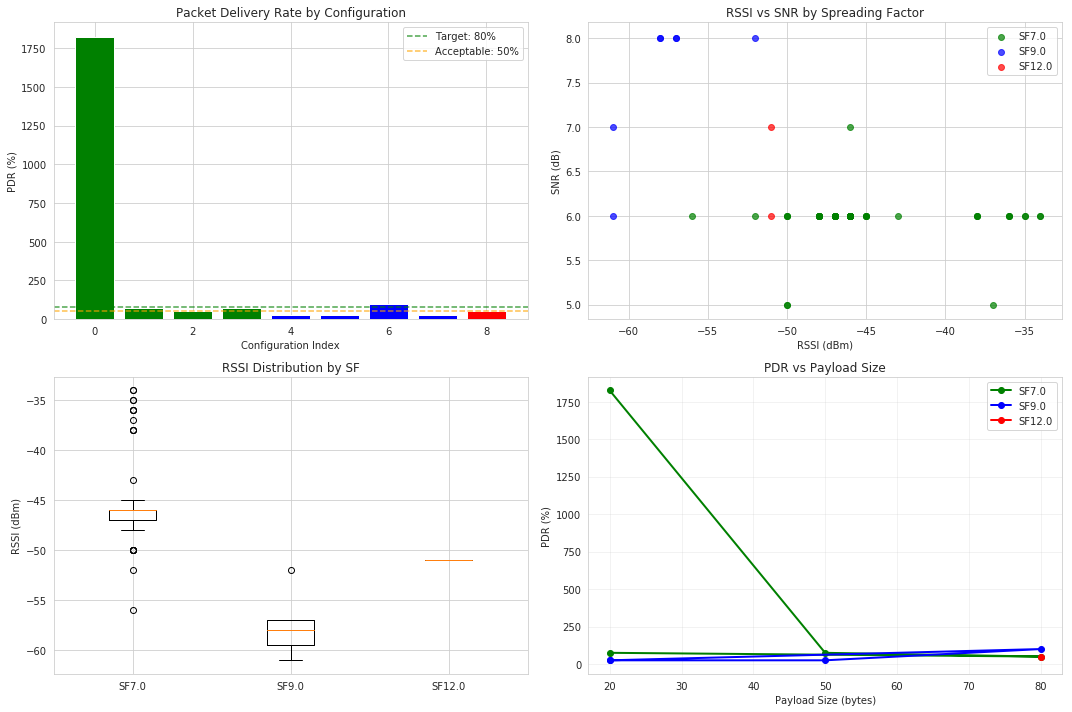

In [19]:
# PDR Analysis Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# PDR bar chart
ax1.bar(range(len(pdr_stats)), pdr_stats['pdr_percent'], 
        color=['green' if sf==7 else 'blue' if sf==9 else 'red' for sf in pdr_stats['sf']])
ax1.set_title('Packet Delivery Rate by Configuration')
ax1.set_xlabel('Configuration Index')
ax1.set_ylabel('PDR (%)')
ax1.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target: 80%')
ax1.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Acceptable: 50%')
ax1.legend()

# RSSI vs SNR scatter
colors = {7: 'green', 9: 'blue', 12: 'red'}
for sf in df['sf'].unique():
    sf_data = df[df['sf'] == sf]
    ax2.scatter(sf_data['rssi'], sf_data['snr'], c=colors[sf], 
               label=f'SF{sf}', alpha=0.7)
ax2.set_xlabel('RSSI (dBm)')
ax2.set_ylabel('SNR (dB)')
ax2.set_title('RSSI vs SNR by Spreading Factor')
ax2.legend()

# RSSI distribution
sf_values = sorted(df['sf'].unique())
rssi_data = [df[df['sf'] == sf]['rssi'].values for sf in sf_values]
ax3.boxplot(rssi_data, labels=[f'SF{sf}' for sf in sf_values])
ax3.set_title('RSSI Distribution by SF')
ax3.set_ylabel('RSSI (dBm)')

# PDR vs payload size
for sf in sf_values:
    sf_stats = pdr_stats[pdr_stats['sf'] == sf]
    ax4.plot(sf_stats['len'], sf_stats['pdr_percent'], 
            marker='o', linewidth=2, label=f'SF{sf}', color=colors[sf])
ax4.set_xlabel('Payload Size (bytes)')
ax4.set_ylabel('PDR (%)')
ax4.set_title('PDR vs Payload Size')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 1 - PDR Bar Chart

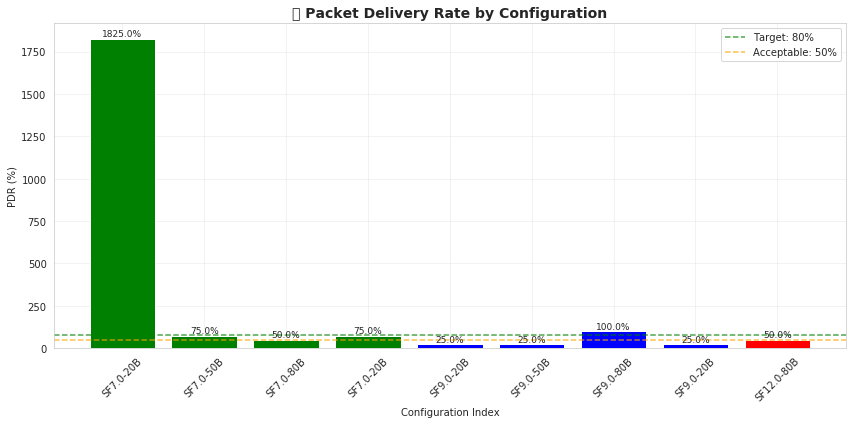

Best PDR: 1825.0%
Worst PDR: 25.0%


In [7]:
# Plot 1: Packet Delivery Rate Bar Chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

colors = ['green' if sf==7 else 'blue' if sf==9 else 'red' for sf in pdr_stats['sf']]
bars = ax.bar(range(len(pdr_stats)), pdr_stats['pdr_percent'], color=colors)

ax.set_title('📊 Packet Delivery Rate by Configuration', fontsize=14, fontweight='bold')
ax.set_xlabel('Configuration Index')
ax.set_ylabel('PDR (%)')
ax.set_xticks(range(len(pdr_stats)))
ax.set_xticklabels([f"SF{row['sf']}-{row['len']}B" for _, row in pdr_stats.iterrows()], rotation=45)

# Add reference lines
ax.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target: 80%')
ax.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Acceptable: 50%')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9)

ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Best PDR: {pdr_stats['pdr_percent'].max():.1f}%")
print(f"Worst PDR: {pdr_stats['pdr_percent'].min():.1f}%")

# RSSI vs SNR Scatter Plot

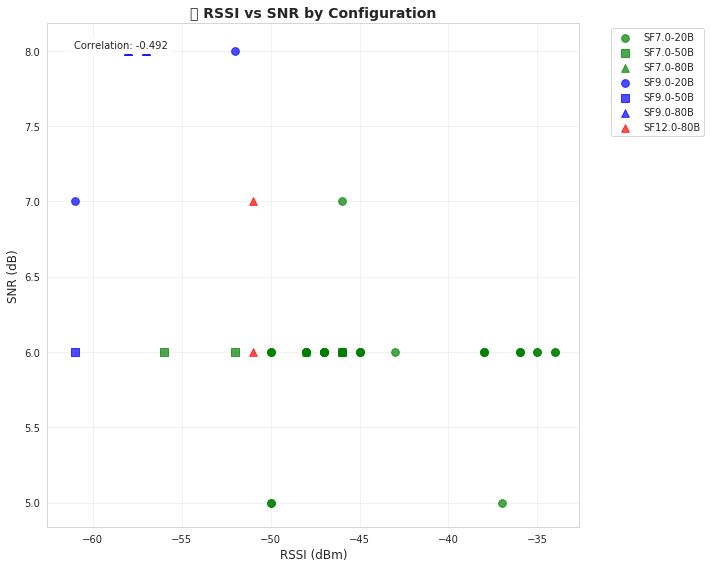

RSSI range: -61.0 to -34.0 dBm
SNR range: 5.0 to 8.0 dB


In [20]:
# Plot 2: RSSI vs SNR Scatter Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

colors = {7: 'green', 9: 'blue', 12: 'red'}
markers = {20: 'o', 50: 's', 80: '^'}  # Different markers for payload sizes

for sf in sorted(df['sf'].unique()):
    for payload in sorted(df['len'].unique()):
        subset = df[(df['sf'] == sf) & (df['len'] == payload)]
        if len(subset) > 0:
            ax.scatter(subset['rssi'], subset['snr'], 
                      c=colors[sf], marker=markers.get(payload, 'o'),
                      label=f'SF{sf}-{payload}B', alpha=0.7, s=60)

ax.set_xlabel('RSSI (dBm)', fontsize=12)
ax.set_ylabel('SNR (dB)', fontsize=12)
ax.set_title('📡 RSSI vs SNR by Configuration', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add correlation info
correlation = df['rssi'].corr(df['snr'])
ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
        transform=ax.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))

plt.tight_layout()
plt.show()

print(f"RSSI range: {df['rssi'].min():.1f} to {df['rssi'].max():.1f} dBm")
print(f"SNR range: {df['snr'].min():.1f} to {df['snr'].max():.1f} dB")

# Signal Quality Box Plots

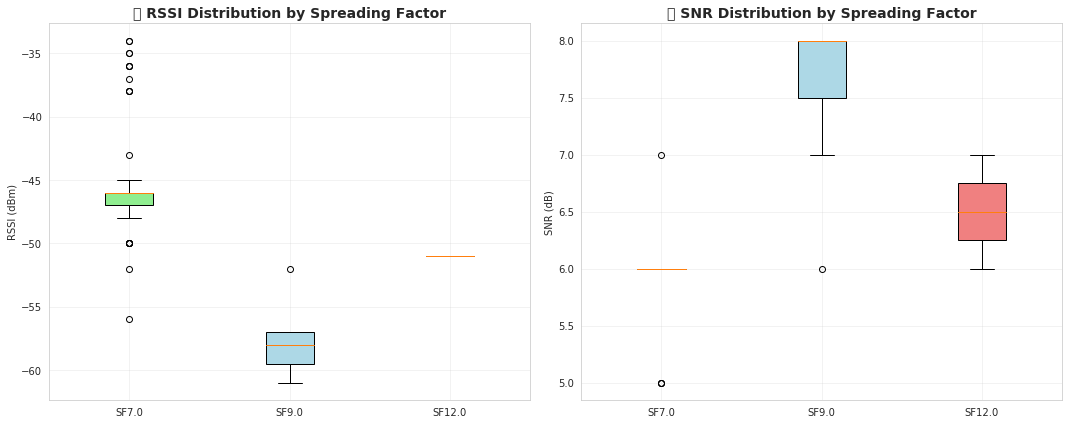

SF7.0: RSSI=-45.3±4.1dBm, SNR=6.0±0.2dB
SF9.0: RSSI=-57.7±3.0dBm, SNR=7.6±0.8dB
SF12.0: RSSI=-51.0±0.0dBm, SNR=6.5±0.7dB


In [21]:
# Plot 3: Signal Quality Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# RSSI distribution by SF
sf_values = sorted(df['sf'].unique())
rssi_data = [df[df['sf'] == sf]['rssi'].values for sf in sf_values]
box1 = ax1.boxplot(rssi_data, labels=[f'SF{sf}' for sf in sf_values], patch_artist=True)

colors = ['lightgreen', 'lightblue', 'lightcoral']
for patch, color in zip(box1['boxes'], colors):
    patch.set_facecolor(color)

ax1.set_title('📶 RSSI Distribution by Spreading Factor', fontsize=14, fontweight='bold')
ax1.set_ylabel('RSSI (dBm)')
ax1.grid(True, alpha=0.3)

# SNR distribution by SF
snr_data = [df[df['sf'] == sf]['snr'].values for sf in sf_values]
box2 = ax2.boxplot(snr_data, labels=[f'SF{sf}' for sf in sf_values], patch_artist=True)

for patch, color in zip(box2['boxes'], colors):
    patch.set_facecolor(color)

ax2.set_title('📊 SNR Distribution by Spreading Factor', fontsize=14, fontweight='bold')
ax2.set_ylabel('SNR (dB)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
for sf in sf_values:
    sf_data = df[df['sf'] == sf]
    print(f"SF{sf}: RSSI={sf_data['rssi'].mean():.1f}±{sf_data['rssi'].std():.1f}dBm, "
          f"SNR={sf_data['snr'].mean():.1f}±{sf_data['snr'].std():.1f}dB")

# PDR vs Payload Size

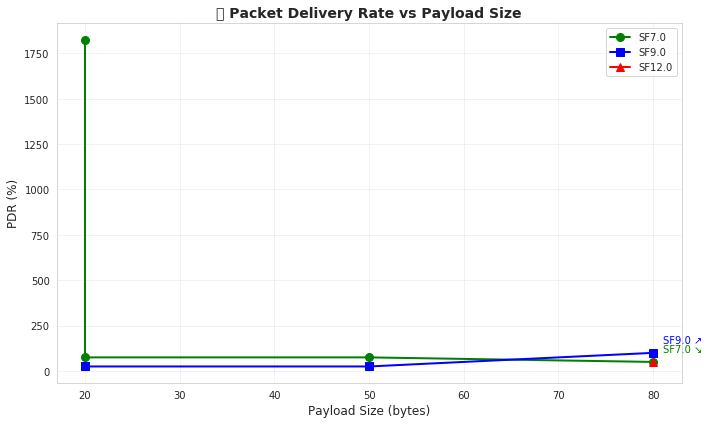

📈 Payload Size Impact Analysis:
SF7.0: PDR range 50.0% - 1825.0%
SF9.0: PDR range 25.0% - 100.0%
SF12.0: PDR range 50.0% - 50.0%


In [10]:
# Plot 4: PDR vs Payload Size Analysis
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

colors = {7: 'green', 9: 'blue', 12: 'red'}
markers = ['o', 's', '^']

for i, sf in enumerate(sorted(pdr_stats['sf'].unique())):
    sf_data = pdr_stats[pdr_stats['sf'] == sf].sort_values('len')
    ax.plot(sf_data['len'], sf_data['pdr_percent'], 
            color=colors[sf], marker=markers[i], linewidth=2, markersize=8,
            label=f'SF{sf}')

ax.set_xlabel('Payload Size (bytes)', fontsize=12)
ax.set_ylabel('PDR (%)', fontsize=12)
ax.set_title('📦 Packet Delivery Rate vs Payload Size', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Add trend annotations
for sf in sorted(pdr_stats['sf'].unique()):
    sf_data = pdr_stats[pdr_stats['sf'] == sf].sort_values('len')
    if len(sf_data) > 1:
        trend = "↗" if sf_data['pdr_percent'].iloc[-1] > sf_data['pdr_percent'].iloc[0] else "↘"
        ax.annotate(f'SF{sf} {trend}', 
                   xy=(sf_data['len'].iloc[-1], sf_data['pdr_percent'].iloc[-1]),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=10, color=colors[sf])

plt.tight_layout()
plt.show()

print("📈 Payload Size Impact Analysis:")
for sf in sorted(pdr_stats['sf'].unique()):
    sf_data = pdr_stats[pdr_stats['sf'] == sf]
    print(f"SF{sf}: PDR range {sf_data['pdr_percent'].min():.1f}% - {sf_data['pdr_percent'].max():.1f}%")

# Cell: Boxplot PDR vs SF

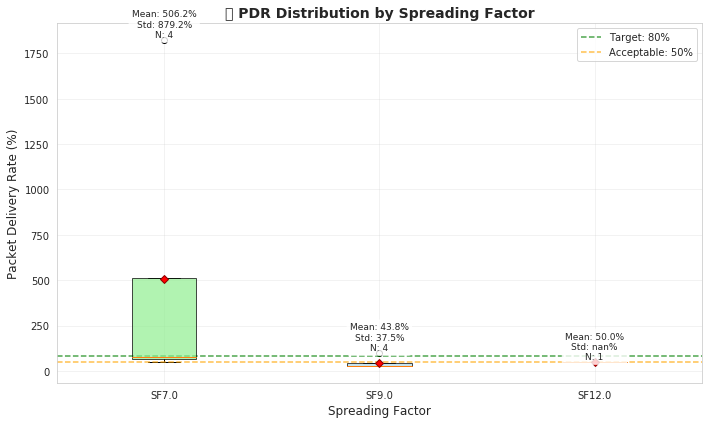

📈 PDR Statistics by Spreading Factor:
----------------------------------------
SF7.0: Mean=506.2%, Median=75.0%, Min=50.0%, Max=1825.0%, Std=879.2%
SF9.0: Mean=43.8%, Median=25.0%, Min=25.0%, Max=100.0%, Std=37.5%
SF12.0: Mean=50.0%, Median=50.0%, Min=50.0%, Max=50.0%, Std=nan%

🔬 ANOVA Test:
F-statistic: 0.610, p-value: 0.574
❌ No significant difference between SF groups (p ≥ 0.05)


In [11]:
# Boxplot: PDR vs Spreading Factor
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Prepare data for boxplot - group PDR values by SF
sf_values = sorted(pdr_stats['sf'].unique())
pdr_by_sf = []

for sf in sf_values:
    sf_data = pdr_stats[pdr_stats['sf'] == sf]['pdr_percent'].values
    pdr_by_sf.append(sf_data)

# Create boxplot
box_plot = ax.boxplot(pdr_by_sf, labels=[f'SF{sf}' for sf in sf_values], 
                      patch_artist=True, showmeans=True)

# Color the boxes
colors = ['lightgreen', 'lightblue', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors[:len(sf_values)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Customize means markers
for mean in box_plot['means']:
    mean.set_marker('D')  # Diamond shape
    mean.set_markerfacecolor('red')
    mean.set_markeredgecolor('darkred')
    mean.set_markersize(6)

ax.set_title('📊 PDR Distribution by Spreading Factor', fontsize=14, fontweight='bold')
ax.set_xlabel('Spreading Factor', fontsize=12)
ax.set_ylabel('Packet Delivery Rate (%)', fontsize=12)

# Add reference lines
ax.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target: 80%')
ax.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Acceptable: 50%')

# Add grid
ax.grid(True, alpha=0.3)
ax.legend()

# Add statistics annotations
for i, sf in enumerate(sf_values):
    sf_data = pdr_stats[pdr_stats['sf'] == sf]['pdr_percent']
    mean_val = sf_data.mean()
    std_val = sf_data.std()
    
    # Add text box with statistics
    stats_text = f'Mean: {mean_val:.1f}%\nStd: {std_val:.1f}%\nN: {len(sf_data)}'
    ax.text(i+1, max(sf_data) + 2, stats_text, 
            ha='center', va='bottom', fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics
print("📈 PDR Statistics by Spreading Factor:")
print("-" * 40)
for sf in sf_values:
    sf_data = pdr_stats[pdr_stats['sf'] == sf]['pdr_percent']
    print(f"SF{sf}: Mean={sf_data.mean():.1f}%, Median={sf_data.median():.1f}%, "
          f"Min={sf_data.min():.1f}%, Max={sf_data.max():.1f}%, Std={sf_data.std():.1f}%")

# Statistical significance test (if scipy available)
try:
    from scipy import stats
    if len(sf_values) >= 2:
        pdr_groups = [pdr_stats[pdr_stats['sf'] == sf]['pdr_percent'].values for sf in sf_values]
        f_stat, p_value = stats.f_oneway(*pdr_groups)
        print(f"\n🔬 ANOVA Test:")
        print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")
        if p_value < 0.05:
            print("✅ Significant difference between SF groups (p < 0.05)")
        else:
            print("❌ No significant difference between SF groups (p ≥ 0.05)")
except ImportError:
    print("\n📊 Install scipy for statistical significance testing")

# Signal Quality Heatmaps

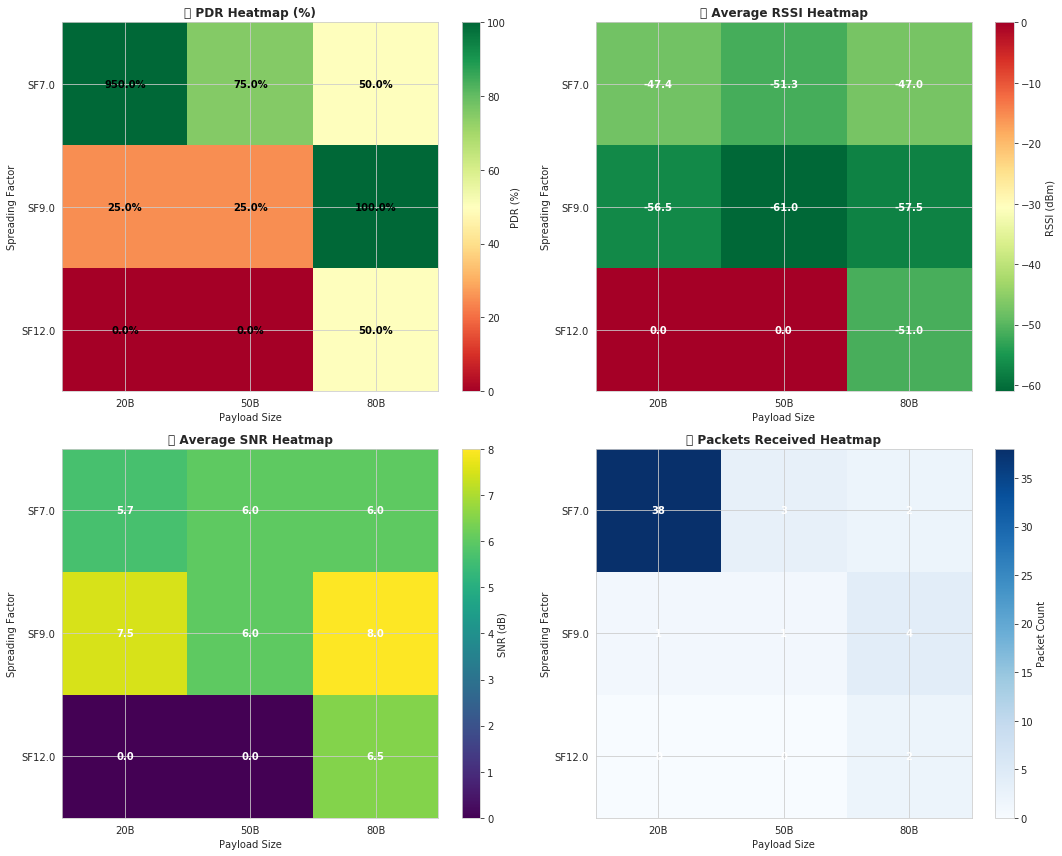

In [12]:
# Plot 5: Performance Heatmaps
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# PDR Heatmap
pdr_pivot = pdr_stats.pivot_table(values='pdr_percent', index='sf', columns='len', fill_value=0)
im1 = ax1.imshow(pdr_pivot.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
ax1.set_title('✅ PDR Heatmap (%)', fontsize=12, fontweight='bold')
ax1.set_xticks(range(len(pdr_pivot.columns)))
ax1.set_xticklabels([f'{col}B' for col in pdr_pivot.columns])
ax1.set_yticks(range(len(pdr_pivot.index)))
ax1.set_yticklabels([f'SF{idx}' for idx in pdr_pivot.index])
ax1.set_xlabel('Payload Size')
ax1.set_ylabel('Spreading Factor')

# Add text annotations
for i in range(len(pdr_pivot.index)):
    for j in range(len(pdr_pivot.columns)):
        text = ax1.text(j, i, f'{pdr_pivot.values[i, j]:.1f}%',
                       ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im1, ax=ax1, label='PDR (%)')

# RSSI Heatmap
rssi_pivot = pdr_stats.pivot_table(values='rssi_mean', index='sf', columns='len', fill_value=0)
im2 = ax2.imshow(rssi_pivot.values, cmap='RdYlGn_r', aspect='auto')
ax2.set_title('📡 Average RSSI Heatmap', fontsize=12, fontweight='bold')
ax2.set_xticks(range(len(rssi_pivot.columns)))
ax2.set_xticklabels([f'{col}B' for col in rssi_pivot.columns])
ax2.set_yticks(range(len(rssi_pivot.index)))
ax2.set_yticklabels([f'SF{idx}' for idx in rssi_pivot.index])
ax2.set_xlabel('Payload Size')
ax2.set_ylabel('Spreading Factor')

for i in range(len(rssi_pivot.index)):
    for j in range(len(rssi_pivot.columns)):
        text = ax2.text(j, i, f'{rssi_pivot.values[i, j]:.1f}',
                       ha="center", va="center", color="white", fontweight='bold')

plt.colorbar(im2, ax=ax2, label='RSSI (dBm)')

# SNR Heatmap
snr_pivot = pdr_stats.pivot_table(values='snr_mean', index='sf', columns='len', fill_value=0)
im3 = ax3.imshow(snr_pivot.values, cmap='viridis', aspect='auto')
ax3.set_title('📶 Average SNR Heatmap', fontsize=12, fontweight='bold')
ax3.set_xticks(range(len(snr_pivot.columns)))
ax3.set_xticklabels([f'{col}B' for col in snr_pivot.columns])
ax3.set_yticks(range(len(snr_pivot.index)))
ax3.set_yticklabels([f'SF{idx}' for idx in snr_pivot.index])
ax3.set_xlabel('Payload Size')
ax3.set_ylabel('Spreading Factor')

for i in range(len(snr_pivot.index)):
    for j in range(len(snr_pivot.columns)):
        text = ax3.text(j, i, f'{snr_pivot.values[i, j]:.1f}',
                       ha="center", va="center", color="white", fontweight='bold')

plt.colorbar(im3, ax=ax3, label='SNR (dB)')

# Packet Count Heatmap
count_pivot = pdr_stats.pivot_table(values='packets_received', index='sf', columns='len', fill_value=0)
im4 = ax4.imshow(count_pivot.values, cmap='Blues', aspect='auto')
ax4.set_title('📊 Packets Received Heatmap', fontsize=12, fontweight='bold')
ax4.set_xticks(range(len(count_pivot.columns)))
ax4.set_xticklabels([f'{col}B' for col in count_pivot.columns])
ax4.set_yticks(range(len(count_pivot.index)))
ax4.set_yticklabels([f'SF{idx}' for idx in count_pivot.index])
ax4.set_xlabel('Payload Size')
ax4.set_ylabel('Spreading Factor')

for i in range(len(count_pivot.index)):
    for j in range(len(count_pivot.columns)):
        text = ax4.text(j, i, f'{int(count_pivot.values[i, j])}',
                       ha="center", va="center", color="white", fontweight='bold')

plt.colorbar(im4, ax=ax4, label='Packet Count')

plt.tight_layout()
plt.show()

# Cell 6: Summary Analysis

In [13]:
# Analysis Summary
print("🔬 ANALYSIS RESULTS")
print("=" * 50)

# Best/worst configurations
best_idx = pdr_stats['pdr_percent'].idxmax()
worst_idx = pdr_stats['pdr_percent'].idxmin()

print(f"\n🏆 Best Configuration:")
best = pdr_stats.iloc[best_idx]
print(f"   SF{best['sf']}, BW{best['bw']}, {best['len']}B payload")
print(f"   PDR: {best['pdr_percent']}%, RSSI: {best['rssi_mean']:.1f}dBm")

print(f"\n❌ Worst Configuration:")
worst = pdr_stats.iloc[worst_idx]
print(f"   SF{worst['sf']}, BW{worst['bw']}, {worst['len']}B payload")
print(f"   PDR: {worst['pdr_percent']}%, RSSI: {worst['rssi_mean']:.1f}dBm")

print(f"\n📊 Overall Statistics:")
print(f"   Average PDR: {pdr_stats['pdr_percent'].mean():.1f}%")
print(f"   RSSI range: {df['rssi'].min():.1f} to {df['rssi'].max():.1f} dBm")
print(f"   SNR range: {df['snr'].min():.1f} to {df['snr'].max():.1f} dB")

print(f"\n⏱️ Timing Recommendations:")
for sf in sorted(df['sf'].unique()):
    sf_pdr = pdr_stats[pdr_stats['sf'] == sf]['pdr_percent'].mean()
    if sf_pdr < 50:
        rec = "Increase interval to 15-20s"
    elif sf_pdr < 75:
        rec = "Increase interval to 10-12s"
    else:
        rec = "Current timing acceptable"
    print(f"   SF{sf}: Avg PDR={sf_pdr:.1f}% → {rec}")

🔬 ANALYSIS RESULTS

🏆 Best Configuration:
   SF7.0, BW125.0, 20B payload
   PDR: 1825.0%, RSSI: -44.9dBm

❌ Worst Configuration:
   SF9.0, BW125.0, 20B payload
   PDR: 25.0%, RSSI: -52.0dBm

📊 Overall Statistics:
   Average PDR: 250.0%
   RSSI range: -61.0 to -34.0 dBm
   SNR range: 5.0 to 8.0 dB

⏱️ Timing Recommendations:
   SF7.0: Avg PDR=506.2% → Current timing acceptable
   SF9.0: Avg PDR=43.8% → Increase interval to 15-20s
   SF12.0: Avg PDR=50.0% → Increase interval to 10-12s
